# Introduction
In this practical we introduce the idea of reinforcement learning, discuss how it differs from supervised and unsupervised learning and then build an agent that learns to drive a car up the mountain.

# Learning Objectives
* Understand the relationship between the **environment** and the  **agent**  
* Understand how a **policy** is used by an agent to select an action
* Describe how to implement a **run-loop** that controls the interaction between environement and agent.
* Understand how the **state**, **action** and **reward** are communicated between the agent and the environment.  
* Be able to implement the a simple **Q-learning** RL algorithm call **DQN**
* Discover at least one potential issue with the DQN.

 # A) Learning Paradims
**Supervised learning: ** is a learning paradaim, given an input and a target value or class. The goal is to predict the class value.

**Unsupervised learning: ** is a learning paradaim, where we are only given an input. The goal is to look for patterns in that input. 

**Reinforcement learning: ** which cares about training an **agent** to maximise a **reward** it obtains through interaction with an **environment**. 


# B) Reinforcement Learning ( RL )

#### How RL works?

The **environment** defines a set of **actions** that an agent can take. The agent observes the current **state** of the environment, tries actions and *learns* a **policy** which is a distribution over the possible actions given a state of the environment. 

The following diagram illustrates the interaction between the agent and environment. We will explore each of the terms in more detail throughout this practical. 


![RL Overview](data/rl-image.png)


# C) Outlines

We will use an OpenAI Gym environment called **Mountain Car**, the goal is to train an agent to drive a car up the mountain. The practical will be as follows:

1. Introduce the **Mountain Car** environment and explore the states and actions available.
2. Create a simple agent that takes random actions.
3. Going from random agent to skilled agent:
    - Introduce Q-learning algorithm.
    - The intuition behind Q-learning.
    - Ways to implement Q-learning:
        - Tabular Method
        - Function approximator: Neural Network.
        
4. Merge Q-learning with Deep Learning:
    - Introduce DQN algorithm.
    - Play with DQN!!
  
5. Dive deeper into DQN:
    - DQN main momponents
    - Implement the components.
    - Stack the components together.
    
6. The big picture of Reinforcement learing:
    - General RL taxonomy
        - Value function based method.
        - Gradient based Methods.
        - Hybrid based Methods.
    - Drawback of the Value function Methods.
    - Next Steps.

7. References.

# 1- Explore the Environment

![SegmentLocal](data/environment.gif "segment")

 The goal is to drive up the mountain on the right; however, the car's engine is not strong enough to scale the mountain in a single pass. Therefore, the only way to succeed is to drive back and forth to build up momentum.

Now let us take a look to how the states and actions represented:

**States:**


|Representation |  State |   Min value|  Max value  |
|---|---------------|------|-------|
| 0 |  position |  -1.2 |     0.6 | 
| 1 |   velocity|   -0.07|     0.07 | 


**Actions:**


|Representation |  Action| 
|---|---------------|
| 0 |  push left |
| 1 |   no push|  
| 2 |    push right|  



In [1]:
import gym

In [2]:
mountain_car = gym.make('MountainCar-v0')
# mountain_car = gym.make('CartPole-v0')

num_states = mountain_car.observation_space.shape[0]
num_actions = mountain_car.action_space.n

print("States:  {} Type: Contiuous  Represented as: Vector ".format(num_states,) )
print("Actions: {} Type: Discrete   Represented as: scalar or number ".format(num_actions+1))  # adding one, because action are starting from 0.
print("Example of a state: ", mountain_car.observation_space.sample())
print("Example of an action: ", mountain_car.action_space.sample())

States:  2 Type: Contiuous  Represented as: Vector 
Actions: 4 Type: Discrete   Represented as: scalar or number 
Example of a state:  [-0.2121357   0.03012651]
Example of an action:  1


# 2- Build a random agent

**reset:** get an initial state in the envirnoment.

**render:** show the mountain car environemnt (simulator) in the screen.

**step:** apply the action in the environemnt.

**smaple:** sample an action

**close:**  close the envrinment ( simulator ).


In [3]:
mountain_car.reset()
for _ in range(1000):
    mountain_car.render()
    random_agent = mountain_car.action_space.sample()
    mountain_car.step(random_agent) # take a random action
mountain_car.close()

# 3- Going from random agent to skilled agent

### 3.1 Q-learning

As we mentioned before, the goal of Reinforcement learning is to train an agent to maximise a reward it obtains through interaction with an environment.

So, what is reward that the agent want to maximize?

Basically, it is the objective function of the agent, and has another name called Reward function. It formalized matmatically as:

$ G_t = r_t + \gamma r_{t+1} + \gamma^{2} r_{t+2} + \gamma^{3} r_{t+3} + .... =  \sum_{t=1}^{T_i} \gamma^t r_{i,t}$

Q-learning considers that every action in a given state has a value $ Q(s_t,a_t)$, this value formalized matmatically as:


$ Q(s_t,a_t) = Q(s_t,a_t) + \alpha [r_{t} + \max_{a} \gamma Q(s_{t+1},a) - Q(s_t,a_t) ] $

which is equal to : $ E[G_t|\space s_t ,a_t]$

Looking for a proof for the previous formula? go here.

### 3.2  The intuition behind Q-learning.

Now, Let us get the intiution behind this formula:


$ Q(s_t,a_t) = Q(s_t,a_t) + \alpha [r_{t} + \max_{a} \gamma Q(s_{t+1},a) - Q(s_t,a_t) ] $

$Q(s_t,a_t) \equiv Action \space value \space a_t \space at \space state \space s_t \\
\max_{a} \gamma Q(s_{t+1},a) \equiv max \space action \space value \space over \space all \space the \space actions \space in \space the \space next \space state \space s_{t+1} \equiv is \space called \space TD \space target \\ 
[r_{t} + \max_{a} \gamma Q(s_{t+1},a) - Q(s_t,a_t) ] \equiv is \space called \space TD \space error.
$

The formula actually saying: the value of the action depends on its previous value plus the discount rewards since taking that action and onward.
This the discount rewards representes TD target.

### 3.3 Ways to implement Q-learning

1. You can implement Q-learning using:

    - Q-Table ( Dictionary, Matrix ,.... ) : Each cell in the table represents action value in a given state.
    - Function Approximation: Because of the increasing of the Q-table with number of states. approximate the action value.
             
|   |  |  Q-Table |    |
|---|---------------|------|-------|---
| $s_0$ |  $a_{00}$|  $a_{01}$|     $a_{02}$ | $a_{03}$ | ... |...$a_{0n}$...
| $s_1$ |    $a_{10}$|  $a_{11}$|     $a_{12}$ | $a_{13}$ | ... |...$a_{1n}$...
| $s_2$ |   $a_{20}$|  $a_{21}$|     $a_{22}$ | $a_{23}$ | ... |...$a_{2n}$...
| $s_3$|   $a_{30}$|  $a_{31}$|     $a_{32}$ | $a_{33}$ | ... |...$a_{3n}$...
| .. |  ..|  ..|      .. | .. | ... |...
        
   

# 4- Merge Q-learning with Deep Learning

#### 4.1 Train the agent

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from DQN import Agent
from DQN import run
from DQN import Metric

Using TensorFlow backend.


In [5]:
# Create the Agent
agent = Agent(env=mountain_car)

In [8]:
# Evaluation settings
episode_number = 0
max_episodes=1000
metric = Metric(max_episodes)


In [9]:
while episode_number<max_episodes:
    
    metric.reset()
    
    R,episode_length= run(agent,mountain_car)
    
    metric.add(R,episode_number,episode_length)
 
    episode_number += 1
    
    
    if episode_number%100==0:
        
        metric.show()       

Episode:  100
Rewards:  -200.0
Max reward so far:  -200.0
Mean Reward -200.0
Episode:  200
Rewards:  -200.0
Max reward so far:  -200.0
Mean Reward -200.0
Episode:  300
Rewards:  -200.0
Max reward so far:  -200.0
Mean Reward -200.0
Episode:  400
Rewards:  -200.0
Max reward so far:  -145.0
Mean Reward -199.7975
Episode:  500
Rewards:  -200.0
Max reward so far:  -145.0
Mean Reward -199.65
Episode:  600
Rewards:  -177.0
Max reward so far:  -129.0
Mean Reward -198.47333333333333
Episode:  700
Rewards:  -165.0
Max reward so far:  -102.0
Mean Reward -197.05428571428573
Episode:  800
Rewards:  -157.0
Max reward so far:  -84.0
Mean Reward -193.565
Episode:  900
Rewards:  -106.0
Max reward so far:  -84.0
Mean Reward -188.82666666666665
Episode:  1000
Rewards:  -200.0
Max reward so far:  -84.0
Mean Reward -184.549


In [10]:
# Save the agent
agent.brain.model.save('Models/dqn.mod')

Text(0.5, 0, 'Number of episodes')

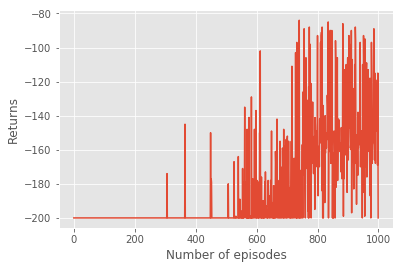

In [11]:
# Plot the result

plt.plot(metric.G)
plt.ylabel('Returns')
plt.xlabel('Number of episodes')

Text(0.5, 0, 'Number of episodes')

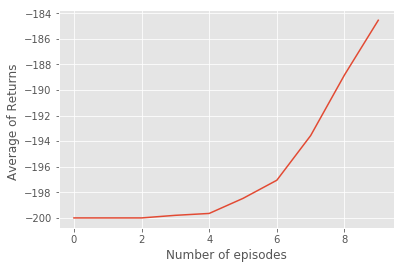

In [12]:
plt.plot(metric.mean_G_all)
plt.ylabel('Average of Returns ')
plt.xlabel('Number of episodes')

Text(0.5, 0, 'Number of Episodes')

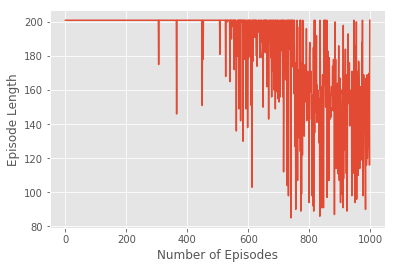

In [13]:
plt.plot(metric.episodes_length)
plt.ylabel('Episode Length')
plt.xlabel('Number of Episodes')

#### 4.2 Test the agent

Now, let's see how much our get better.

In [14]:
for i in range(20):
    _,_= run(agent,mountain_car, train=False)

# 5- Dive deeper into DQN:

In this section, we are going to implement DQN from scratch!. the section will introduce DQN components first, then we will try to stack these components together, to get a fully DQN algorithm.

## 5.1- DQN Components:

DQN algorithm consists of 3 main components:

   1. Function approximator ( Neural Network ) .
   2. Reply buffer. ( Memory )
   3. Policy.

### 1. Function approximator

- Any machine learning algorithm can be seen as a function approximator, DQN algorithm uses the Neural Network as a function approximator. In the case of DQN the neural network outputs continuous value. 

- There are many deep learning frameoworks to implement the neural networks. This tutorial is based on Keras. Keras is a high API for other deep learning frameworks, such as Tensorflow, Theano and the CNTK.

- DQN uses the neural network to predict the action value in a given state $Q(s,a)$ . 
The Brain class represents the neural netowrks. It consists of 3 functions:
    -  create() : Which create the neural network.
    -  train():   train the model.
    -  predict(): predict the Q(s,a) value, it takes a state and output Q(s,a).

In [5]:
# Brain Settings:

#batch_size=64
#hidden_units=64
#

class Brain:
    def __init__(self,state_size, action_size,batch_size, hidden_units,learning_rate):
        
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = batch_size
        self.hidden_units = hidden_units
        self.lr = learning_rate
        
        self.params = {}
        self.model= self._create()
        # self.model.load_weights("cartpole-basic.h5")
        
    def _create(self):
        
        model = Sequential()
        model.add(layers.Dense(units=self.hidden_units, activation='relu', input_dim= self.state_size))
        model.add(layers.Dense(units= self.action_size, activation='linear'))        
        
       
        optimizer = optimizers.adam(lr=self.lr)
        model.compile(loss='mse', optimizer=optimizer)
        

        return model

    def train(self, x, y, epoch=1, verbose=0):
        self.model.fit(x, y, batch_size=self.batch_size,epochs=epoch, verbose=verbose)
        

    def predict(self, s):
        
        return self.model.predict(s,batch_size=self.batch_size)


### 2. Experience Replay Buffer.

- DQN use a memory to store the episode data $(s_t , a_t , r_t, s_{t+1})$ as a training set. 
- Experience increase the stability of the learning.
- Experience replay averages the behavior distribution over many of its previous states, smoothing out learning and avoiding oscillations or divergence in the network parameters.

In [6]:
# Memory

class Memory:   # stored as ( s, a, r, s_ )
    samples = []

    def __init__(self, capacity):
        self.capacity = capacity

    def add_sample(self, sample):
        self.samples.append(sample)        

        if len(self.samples) > self.capacity:
            self.samples.pop(0)

    def get_sample(self, n):
        n = min(n, len(self.samples))
        return random.sample(self.samples, n)

### 3. Policy.

- Policy: a policy is a function that map from state to action, not action value but action. $ \pi(s):a$
- In this tutorial, we implement the policy as a python class. The calss have 2 functions:
    - get_action: take an state and return the action.It return a random action with probability $\epsilon$ and an action based on the the output of the neural network with probability $1-\epsilon$.
    
    - decay_epsilon: which encourages the agent to take actions that not depending on its main policy. In the begining $\epsilon$ value is high which encourages the agent to take random actions, and through the time it gets to decay which let the agent take actions based on its own policy ( the Brain or Neural Network). 

In [ ]:
class Policy:

    epsilon = MAX_EPSILON
    
    def __init__(self, ACTION_COUNT):
        self.ACTION_COUNT = ACTION_COUNT
        pass
    
    def get_action(self,s,brain):
        
        if random.random() < self.epsilon:
            return random.randint(0, self.ACTION_COUNT-1)
        else:
            s=np.reshape(s,newshape=(1,s.shape[0]))
            return np.argmax(brain.predict(s)) 
    
    def decay_epsilon(self,steps):
        self.epsilon = MIN_EPSILON + (MAX_EPSILON - MIN_EPSILON) * math.exp(-LAMBDA * steps)
        return self.epsilon

## 5.2  Stack the component together

- In the previous section, we introduce DQN main components, in this section we will combine these components together to make DQN algorithm.

- To combine these components, we define a class called Agent, which will use all the previous code when it is intracing with environment. 

- Our Agent consists from 3 functions:
    - act(): take a state and return an action. it uses: get_action in policy class.
    - observe(): take  $(s_t , a_t , r_t, s_{t+1})$ and save in the memory or the Replay buffer. it uses:
        - add sample from Memory class.
        - decay_epsilon from Policy class.
        
    - replay(): update the neural network parameters. It uses:
        - get_sample in Memory class.
        - predict in Brain class.
        - train in Brain classs.
        
- Because Replay is an important function, this how it works:
    - It request data from the Memory, the number of samples from the memory called Batch. Each samples consist of $(s_t, a_t, r_t, s_{t+1})$.
   
    - Predict the actions values of all the $s_t$.
    - Predict the actions values of all the $s_{t+1}$.
    - Update the actions values of $s_t$.
    - Construct the data to update the Neural Network. data consists of:
        - X represents the states.
        - y represents the actions values that corsponding to each state. 
    - Update the Networks with the constructed data.
    

In [ ]:
class Agent:
    steps = 0

    def __init__(self, env):
        self.env = env
        self.STATE_COUNT  = self.env.observation_space.shape[0]
        self.ACTION_COUNT = self.env.action_space.n
    
        self.brain = Brain(self.STATE_COUNT,self.ACTION_COUNT)
        self.memory = Memory(MEMORY_CAPACITY)
        self.policy = Policy(self.ACTION_COUNT)
        
    def act(self, s):
        action=self.policy.get_action(s,self.brain)
        return action

    def observe(self, sample):  # in (s, a, r, s_) format
        self.memory.add_sample(sample)    
        # slowly decrease Epsilon based on our eperience
        self.steps += 1
        self.policy.decay_epsilon(self.steps)

    def replay(self):    
        batch = self.memory.get_sample(BATCH_SIZE)
        batchLen = len(batch)

        no_state = np.zeros(self.STATE_COUNT)

        
        states = np.array([ o[0] for o in batch ], dtype=np.float32)
        states_ = np.array([(no_state if o[3] is None else o[3]) for o in batch ], dtype=np.float32)

        p = self.brain.predict(states)
        p_ = self.brain.predict(states_)

        x = np.zeros((batchLen, self.STATE_COUNT)).astype(np.float32)
        y = np.zeros((batchLen, self.ACTION_COUNT)).astype(np.float32)
        
        for i in range(batchLen):
            s, a, r, s_ = batch[i]
            
            action_values = p[i]
            if s_ is None:
                action_values[a] = r
                
            else:
                action_values[a] = r + GAMMA * np.amax(p_[i])      # calculate the target: r+ Gamma*max Q(s',a')

            x[i] = s
            y[i] = action_values

        self.brain.train(x, y)

## 5.3 Run the code

- Follow these steps to implement the run function below:

    - Create an object from the Agent class.
    - Loop over the number of iterations.
    - Loop over the number of time step.
    - Use act() function to apply action in the environment through step() function.
    - Step() will returns the episode trajectory, save it in the memory.
    - Use replay() function to update the network.

In [8]:
def run(agent, env):
    s = env.reset()
    R = 0 

    while True:     

        a = agent.act(s.astype(np.float32))

        s_, r, done, info = env.step(a)


        if done: # terminal state
            s_ = None
        
        
        agent.observe((s, a, r, s_))
        agent.replay()            

        s = s_
        R += r

        if done:
            env.close()
            return R

In [ ]:
agent = Agent()    # Create an object from the Agent class.

In [ ]:
episode_number = 0
number_of_episodes=1000

while episode_number<number_of_episodes:
    episode_states=[]
    episode_rewards=[]
    episode_actions=[]
    episode_length_counter=1
    
    R,episode_length_counter= run(agent)
    
    G.append(R)
    reward_sum=sum(G)

    episode_number += 1

    if episode_number%100==0:
                
        print("==========================================")
        print("Episode: ", episode_number)
        print("Rewards: ", R)
        print("Max reward so far: ", max(G))

# 6. The Big Picture of Reinforcement learing:

## 6.1 General RL taxonomy

- RL algorithms can be divided to 3 types:
    - Value functions based Methods.
    - Policy based Methods.
    - Hybrid Methods.

### A) Value function Methods:

- A value functions methods consider that every state or action has a value that can be learned, and then taking decisions based on those values. ( i.e taking actions based on the values of the actions) .

- As an example to a value function method, DQN algorithm.

### B) Policy function Methods:

- Policy function methods don't need to learn values for actions or states to take decisions.
- These methods, their inputs are the state features and the ouputs are the actions or state . $\pi(s/0 -> a$
- They more stable more than Value function mthods.
- Example: DDPG algorithm.

### C) Hybrid Methods:

- These methods use the seconds methods above. 
- Example tp some of these methods, ACTOR Critic algorithm.

## 6.2 Drawback of Value function Methods.

- Can't be used in problems that have high dimension action space.

# 7- References

 - Introductioon to Reinforcement learning by David Silver.
 - Deep Reinforcement Learning by Sergey Levine.

# 8- Next Steps.